# Aquarium Dataset Classification using EfficientDet

## Performance Comparison of Similar Models

<figure>
<img src="https://blog.roboflow.com/content/images/2020/06/yolov5-performance.png" style="width:700px">
</figure>

Check out the [EfficientDet Research Paper ](https://arxiv.org/pdf/1911.09070.pdf)  

## EfficientDet Structure
![image](https://aihub-storage.s3.ap-northeast-2.amazonaws.com/file/efficientdet.png)

### Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import os

In [2]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision.transforms import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
import cv2
from PIL import Image
import albumentations as A
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes

In [4]:
!pip install pycocotools timm effdet
from pycocotools.coco import COCO
import timm
import effdet

     |████████████████████████████████| 106 kB 901 kB/s            
  Installing build dependencies ... - \ | / - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     |████████████████████████████████| 431 kB 4.4 MB/s            
     |████████████████████████████████| 112 kB 23.8 MB/s            
     |████████████████████████████████| 74 kB 2.2 MB/s             
     |████████████████████████████████| 112 kB 25.3 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp37-cp37m-linux_x86_64.whl size=370022 sha256=e73d18d1d818575c41379b0460a6e4f0af827544858d158c0158fba9cd48e7f0
  Stored in directory: /root/.cache/pip/wheels/a3/5f/fa/f011e578cc76e1fc5be8dce30b3eb9fd00f337e744b3bba59b
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=05bd61cf179f04e448d429030d6927ea48bb8142375

### Augmentation With Albumentations

In [5]:
from albumentations.pytorch import ToTensorV2

In [6]:
def get_albumentation(train):
    if train:
        transform = A.Compose([
            A.Resize(512, 512),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(512, 512),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

### Dataset

In [7]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(
        self,
        root: str,
        split = "train",
        transform= None,
        target_transform = None,
        transforms = None,
    ) -> None:
        super().__init__(root, transforms, transform, target_transform)
        self.split = split
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int) -> Image.Image:
        path = self.coco.loadImgs(id)[0]["file_name"]
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def _load_target(self, id: int):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index: int):
        id = self.ids[index]
        image = self._load_image(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target]
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        new_boxes = []
        for box in boxes:
            xmin =  box[0]
            ymin = box[1]
            xmax = xmin + box[2]
            ymax = ymin + box[3]
            new_boxes.append([ymin, xmin, ymax, xmax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        _, h, w = image.shape
        
        targ = {}
        targ["boxes"] = boxes
        targ["labels"] = torch.tensor([t["category_id"]  for t in target], dtype=torch.int64)
        targ["image_id"] = torch.tensor([t["image_id"]  for t in target])
        targ["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        targ["iscrowd"] = torch.tensor([t["iscrowd"]  for t in target], dtype=torch.int64)
        targ["img_scale"] = torch.tensor([1.0])
        targ['img_size'] = (h, w)
        
        image = image.div(255)
        normalize = T.Compose([T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        
        return normalize(image), targ, index


    def __len__(self) -> int:
        return len(self.ids)

In [8]:
dataset_path = "/kaggle/input/aquarium-dataset/Aquarium Combined/"

In [9]:
coc = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coc.cats
n_classes = len(categories.keys())
n_classes, categories

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


(8,
 {0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
  1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
  2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
  3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
  4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
  5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
  6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
  7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}})

In [10]:
classes = []
for i in categories.items():
    classes.append(i[1]["name"])

In [11]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_albumentation(True))
val_dataset = AquariumDetection(root=dataset_path, split="valid", transforms=get_albumentation(False))
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_albumentation(False))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [12]:
inv_normalize = T.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

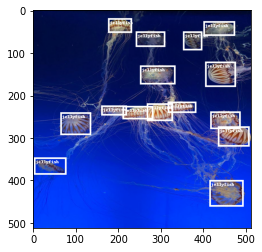

In [13]:
sample = train_dataset[12]
img_int = torch.tensor(inv_normalize(sample[0]) * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(img_int, 
                               sample[1]['boxes'][:, [1, 0, 3, 2]], 
                               [classes[i] for i in sample[1]['labels']],
                               width=4).permute(1, 2, 0)
          )

In [14]:
len(train_dataset), len(val_dataset), len(test_dataset)

(447, 127, 63)

### Build Model

In [15]:
from effdet.config.model_config import efficientdet_model_param_dict
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
from effdet.config.model_config import efficientdet_model_param_dict
from effdet import create_model

In [16]:
def collate_fn(batch):
        images, targets, image_ids = tuple(zip(*batch))
        images = torch.stack(images)
        images = images.float()

        boxes = [target["boxes"].float() for target in targets]
        labels = [target["labels"].float() for target in targets]
        img_size = torch.tensor([target["img_size"] for target in targets]).float()
        img_scale = torch.tensor([target["img_scale"] for target in targets]).float()

        annotations = {
            "bbox": boxes,
            "cls": labels,
            "img_size": img_size,
            "img_scale": img_scale,
        }

        return images, annotations, targets, image_ids

In [17]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=collate_fn
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=collate_fn
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=collate_fn
)

In [18]:
model = create_model('tf_efficientdet_d0' , bench_task='train' , num_classes= n_classes , 
                     image_size=(512,512),
                     bench_labeler=True,pretrained=True)

Downloading: "https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d0_34-f153e0cf.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientdet_d0_34-f153e0cf.pth


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
model = model.to(device)

In [21]:
images, ann, _, indices = next(iter(train_loader))
images = images.to(device)
target = {}
target["bbox"] = [a.to(device) for a in ann['bbox']]
target["cls"] = [a.to(device) for a in ann["cls"]]
target["img_scale"] = (
    torch.tensor([1] * 4).float().to(device)
)
target["img_size"] = (
    torch.tensor( ann["img_size"]).to(device).float()
)
sample_out = model(images, target)

### Model Training

In [22]:
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.01,
#                             momentum=0.9, nesterov=True, weight_decay=1e-4)
optimizer = optim.AdamW(model.parameters(), lr= 2e-4, weight_decay = 1e-6)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1)

In [23]:
from tqdm import tqdm

In [24]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.to(device)
    model.train()
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None

    all_losses = []
    all_losses_dict = []
    
    for images, ann, tgts, indices in tqdm(data_loader):
        images = images.to(device)
        target = {}
        target["bbox"] = [a.to(device) for a in ann['bbox']]
        target["cls"] = [a.to(device) for a in ann["cls"]]
        target["img_scale"] = (
            torch.tensor([1] * 4).float().to(device)
        )
        target["img_size"] = (
            torch.tensor( ann["img_size"]).to(device).float()
        )
        
        loss_dict = model(images, target)

        losses = sum(loss for loss in loss_dict.values())

        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        losses_reduced = sum(loss for loss in loss_dict.values())

        loss_value = losses_reduced.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()
    
    all_losses_dict = pd.DataFrame(all_losses_dict)
    print("Epoch {}: lr: {:.6f} loss: {:.6f}, loss2: {:.6f}, loss_classifier: {:.6f}, loss_box_reg: {:.6f}".format(
        epoch, optimizer.param_groups[0]["lr"], np.mean(all_losses), 
        all_losses_dict["loss"].mean(),
        all_losses_dict["class_loss"].mean(),
        all_losses_dict["box_loss"].mean(),
    ))
    

In [25]:
num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=28)
    lr_scheduler.step()

100%|██████████| 112/112 [00:26<00:00,  4.16it/s]


Epoch 0: lr: 0.000200 loss: 2.553384, loss2: 1.426459, loss_classifier: 1.120812, loss_box_reg: 0.006113


100%|██████████| 112/112 [00:27<00:00,  4.01it/s]


Epoch 1: lr: 0.000200 loss: 1.977836, loss2: 1.109105, loss_classifier: 0.863825, loss_box_reg: 0.004906


100%|██████████| 112/112 [00:27<00:00,  4.02it/s]


Epoch 2: lr: 0.000200 loss: 1.700182, loss2: 0.957525, loss_classifier: 0.738272, loss_box_reg: 0.004385


100%|██████████| 112/112 [00:27<00:00,  4.03it/s]


Epoch 3: lr: 0.000200 loss: 1.527244, loss2: 0.864267, loss_classifier: 0.658869, loss_box_reg: 0.004108


100%|██████████| 112/112 [00:27<00:00,  4.02it/s]


Epoch 4: lr: 0.000200 loss: 1.407198, loss2: 0.797345, loss_classifier: 0.606027, loss_box_reg: 0.003826


100%|██████████| 112/112 [00:27<00:00,  4.05it/s]


Epoch 5: lr: 0.000200 loss: 1.301849, loss2: 0.742590, loss_classifier: 0.555517, loss_box_reg: 0.003741


100%|██████████| 112/112 [00:28<00:00,  3.97it/s]


Epoch 6: lr: 0.000200 loss: 1.240936, loss2: 0.706303, loss_classifier: 0.531129, loss_box_reg: 0.003503


100%|██████████| 112/112 [00:27<00:00,  4.10it/s]


Epoch 7: lr: 0.000200 loss: 1.141662, loss2: 0.650490, loss_classifier: 0.487921, loss_box_reg: 0.003251


100%|██████████| 112/112 [00:28<00:00,  3.97it/s]


Epoch 8: lr: 0.000200 loss: 1.109668, loss2: 0.634645, loss_classifier: 0.471766, loss_box_reg: 0.003258


100%|██████████| 112/112 [00:27<00:00,  4.02it/s]

Epoch 9: lr: 0.000200 loss: 1.047361, loss2: 0.597018, loss_classifier: 0.447349, loss_box_reg: 0.002993


In [26]:
torch.save(model.state_dict(), "tf_effdet_d0_aquarium.pth")

In [27]:
model_inf = create_model('tf_efficientdet_d0' , bench_task='predict' , num_classes= n_classes , 
                     image_size=(512,512),
                     bench_labeler=True,pretrained=False)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


In [28]:
model_inf.load_state_dict(torch.load("tf_effdet_d0_aquarium.pth"))
model_inf = model_inf.to(device)

### Inference

In [29]:
def format_pred(preds):
    return {"boxes": preds[:, :4], "scores": preds[:, 4], "labels": preds[:, 5]}

In [30]:
model_inf.eval()
torch.cuda.empty_cache()

In [31]:
img, _, _ = test_dataset[7]
img_int = torch.tensor(inv_normalize(img) * 255, dtype=torch.uint8)
with torch.no_grad():
    img = img.unsqueeze(0).to(device)
    prediction = model_inf(img)
    pred = format_pred(prediction[0])

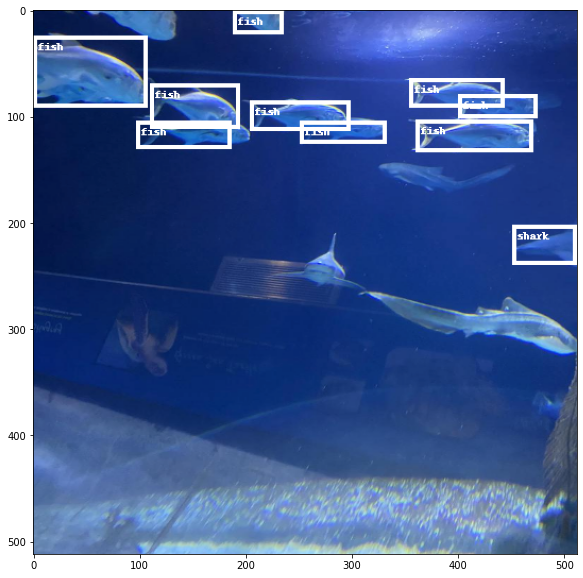

In [32]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int, 
                               pred['boxes'][pred['scores'] > 0.5], 
                               [classes[int(i)] for i in pred['labels'][pred['scores'] > 0.5].tolist()],
                               width=4).permute(1, 2, 0)
          )